# Análisis de las votaciones en el Festival de la Canción de Eurovisión (1956-2023)

In [1]:
import os
import math
import re
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import nearest_points
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import altair as alt
import networkx as nx
import nx_altair as nxa

#Packages for plotting a wordcloud
from ipywidgets import widgets, interact, interactive, fixed, Button, Layout
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from IPython.display import display
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anaso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Customización de la paleta de colores

Inspiración para escoger la paleta: 

- Eurovision 2022: https://www.behance.net/gallery/143410695/Eurovision-2022-Brand-Identity
- Eurovision 2024: https://eurovision.tv/story/eurovision-2024-theme-art-revealed 

Colorblind safety palettes: https://www.nceas.ucsb.edu/sites/default/files/2022-06/Colorblind%20Safe%20Color%20Schemes.pdf

In [2]:
#Set altair dark theme
alt.themes.enable('dark')

ThemeRegistry.enable('dark')

In [3]:
#Color palette 
eurovision_palette = ["#D2B4DE", '#15CAB6', '#F6B53D', '#EF8A5A', '#E85E76', 
                      '#696CB5', '#BABABA', '#156082', '#F4F6FA'] #discrete palette
eurovision_cont_palette = ['#007d79','#15CAB6','#d9fbfb'] #continous palette

#Display palette
eurovision_palette_df = pd.DataFrame({
    'x': range(9),
    'color': eurovision_palette
})

alt.Chart(eurovision_palette_df).mark_point(
    filled=True,
    size=100
).encode(
    x='x',
    color=alt.Color('color').scale(None)
)

alt.Chart(...)

## 1. Importación y preprocesado de los datos

### 1.1. Concursantes

In [4]:
contestants_df = pd.read_csv('./Data/contestants_preprocessed.csv')
contestants_df.head(3)

year to_country_id   to_country    performer  \
0  1956            ch  Switzerland    Lys Assia   
1  1956            nl  Netherlands  Jetty Paerl   
2  1956            be      Belgium  Fud Leclerc   

                              song  place_contest  sf_num  running_final  \
0                          Refrain            2.0     NaN            2.0   
1            De Vogels Van Holland            2.0     NaN            1.0   
2  Messieurs Les Noyés De La Seine            2.0     NaN            3.0   

   running_sf  place_final  ...  place_sf  points_sf  points_tele_final  \
0         NaN          2.0  ...       NaN        NaN                NaN   
1         NaN          2.0  ...       NaN        NaN                NaN   
2         NaN          2.0  ...       NaN        NaN                NaN   

   points_jury_final  points_tele_sf  points_jury_sf               composers  \
0                NaN             NaN             NaN        Georg Benz Stahl   
1                NaN             NaN             NaN             Cor Lemaire   
2                NaN             NaN             NaN  Jacques Say;Jean Miret   

             lyricists                                             lyrics  \
0                  NaN  (Refrain d'amour...)  Refrain, couleur du ciel...   
1  Annie M. G. Schmidt  De vogels van Holland zijn zo muzikaal Ze lere...   
2        Robert Montal  Messieurs les noyés de la Seine Ouvrez-moi les...   

                               youtube_url  
0  https://youtube.com/watch?v=IyqIPvOkiRk  
1  https://youtube.com/watch?v=u45UQVGRVPA  
2  https://youtube.com/watch?v=U9O3sqlyra0  

[3 rows x 21 columns]

In [5]:
contestants_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1734 non-null   int64  
 1   to_country_id      1734 non-null   object 
 2   to_country         1734 non-null   object 
 3   performer          1734 non-null   object 
 4   song               1731 non-null   object 
 5   place_contest      1678 non-null   float64
 6   sf_num             640 non-null    float64
 7   running_final      1398 non-null   float64
 8   running_sf         605 non-null    float64
 9   place_final        1397 non-null   float64
 10  points_final       1385 non-null   float64
 11  place_sf           605 non-null    float64
 12  points_sf          605 non-null    float64
 13  points_tele_final  181 non-null    float64
 14  points_jury_final  181 non-null    float64
 15  points_tele_sf     212 non-null    float64
 16  points_jury_sf     212 n

#### 1.1.1. Limpieza de datos

Algunos países tienen inconsistencias en relación con sus códigos o nombres entre las entradas. Podemos ver, que hay canciones que tienen el nombre completo del país en el campo que debería contener el identificador, países que se ha registrado con un nombre distinto en función del año (e.g. "Czechia" y "Czech Republic"), o países mal escritos (e.g., Macedonia del Norte que aparece como "North MacedoniaN.Macedonia"). 

In [6]:
contestants_df['to_country_id'].unique()

array(['ch', 'nl', 'be', 'de', 'fr', 'lu', 'it', 'dk', 'gb', 'at', 'se',
       'mc', 'no', 'yu', 'es', 'fi', 'pt', 'ie', 'mt', 'il', 'gr', 'tr',
       'ma', 'cy', 'is', 'hr', 'ba', 'si', 'pl', 'hu', 'ru', 'sk', 'ro',
       'ee', 'lt', 'mk', 'lv', 'ua', 'cs', 'al', 'Estonia', 'Israel',
       'Denmark', 'Finland', 'Portugal', 'Lithuania', 'Latvia', 'Andorra',
       'Belarus', 'Monaco', 'Slovenia', 'Switzerland', 'md', 'Poland',
       'Netherlands', 'Ireland', 'Iceland', 'Bulgaria', 'Austria',
       'Belgium', 'am', 'Albania', 'Cyprus', 'rs', 'bg', 'by', 'ge',
       'Croatia', 'Norway', 'Montenegro', 'Malta', 'Czech Republic', 'az',
       'North Macedonia', 'Moldova', 'Hungary', 'San Marino', 'Serbia',
       'Slovakia', 'Sweden', 'Armenia', 'Turkey', 'Georgia', 'me', 'sm',
       'au', 'cz', 'Bosnia & Herzegovina', 'Greece', 'Romania',
       'Azerbaijan', 'Russia', 'Australia', 'Ukraine'], dtype=object)

In [7]:
contestants_df['to_country'].unique()

array(['Switzerland', 'Netherlands', 'Belgium', 'Germany', 'France',
       'Luxembourg', 'Italy', 'Denmark', 'United Kingdom', 'Austria',
       'Sweden', 'Monaco', 'Norway', 'Yugoslavia', 'Spain', 'Finland',
       'Portugal', 'Ireland', 'Malta', 'Israel', 'Greece', 'Turkey',
       'Morocco', 'Cyprus', 'Iceland', 'Croatia', 'Bosnia & Herzegovina',
       'Slovenia', 'Poland', 'Hungary', 'Russia', 'Slovakia', 'Romania',
       'Estonia', 'Lithuania', 'North Macedonia', 'Latvia', 'Ukraine',
       'Serbia & Montenegro', 'Albania', 'Andorra', 'Belarus', 'Moldova',
       'Bulgaria', 'Armenia', 'Serbia', 'Georgia', 'Montenegro',
       'Czech Republic', 'Azerbaijan', 'San Marino', 'Australia',
       'North MacedoniaN.Macedonia', 'Czechia'], dtype=object)

In [8]:
#Data Cleaning
contestants_df.loc[contestants_df['to_country']=='Andorra','to_country_id'] = 'ad'
contestants_df.loc[contestants_df['to_country_id']=='mk','to_country'] = 'North Macedonia'
contestants_df.loc[contestants_df['to_country']=='Czechia','to_country'] = 'Czech Republic'
contestants_df.loc[contestants_df['to_country']=='Bosnia & Herzegovina','to_country'] = 'Bosnia and Herzegovina'
contestants_df.loc[contestants_df['to_country']=='Serbia & Montenegro','to_country'] = 'Serbia and Montenegro'

#### Tratamiento de valores nulos

Aunque se presentaron candidaturas para la edición de 2020, el festival no se llegó a celebrar debido a la pandemia del Covid-19. Por ese motivo, se van a eliminar estos registros de la tabla. 

In [9]:
contestants_df[contestants_df['year']==2020]['place_contest'].isnull().sum()

41

In [10]:
#Drop 2020
contestants_df = contestants_df[contestants_df['year']!=2020]

Si un país no se clasifica para la final, el número de puntos que recibirán en esta ronda será 0. 

In [11]:
contestants_df['points_final'].fillna(0, inplace=True)

#### 1.1.2. Selección/filtrado

In [12]:
columns_filt = ['sf_num', 'running_sf', 'place_sf', 'points_sf', 'points_tele_sf', 
                'points_jury_sf', 'composers', 'lyricists', 'youtube_url']
contestants_df.drop(columns_filt, axis=1, inplace=True)

In [13]:
contestants_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693 entries, 0 to 1733
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1693 non-null   int64  
 1   to_country_id      1693 non-null   object 
 2   to_country         1693 non-null   object 
 3   performer          1693 non-null   object 
 4   song               1690 non-null   object 
 5   place_contest      1678 non-null   float64
 6   running_final      1397 non-null   float64
 7   place_final        1397 non-null   float64
 8   points_final       1693 non-null   float64
 9   points_tele_final  181 non-null    float64
 10  points_jury_final  181 non-null    float64
 11  lyrics             1681 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 3.1 MB


In [14]:
contestants_df[contestants_df['song'].isnull()]

year to_country_id      to_country         performer song  \
366   1979            de         Germany   Dschinghis Khan  NaN   
708   1995            gb  United Kingdom  Love City Groove  NaN   
1152  2009       Belgium         Belgium           Copycat  NaN   

      place_contest  running_final  place_final  points_final  \
366             4.0            9.0          4.0          86.0   
708            10.0           15.0         10.0          76.0   
1152           41.0            NaN          NaN           0.0   

      points_tele_final  points_jury_final  \
366                 NaN                NaN   
708                 NaN                NaN   
1152                NaN                NaN   

                                                 lyrics  
366   Hu, ha, hu, ha... hu, ha, hu, ha... Hu, ha, hu...  
708   We're really makin', we're really makin' We're...  
1152  Way down in Memphis, Tennessee There's a guy l...

#### 1.1.3 Transformación de variables

A continuación se va a añadir el idioma de las canciones para completar este conjunto de datos. El idioma procede de una fuente de datos distinta (https://escincontext.com/resources/data/).

In [15]:
results_df = pd.read_csv('./Data/Every_Eurovision_Result_Ever.csv')
#Capitalize each word in song title to standarize it
results_df['Song'] = results_df['Song'].str.title()
results_df[['Country', 'Year', 'Language', 'Song']].head()

Country  Year Language                             Song
0  Belgium  1956   French      Le Plus Beau Jour De Ma Vie
1  Belgium  1956   French  Messieurs Les Noyés De La Seine
2   France  1956   French                        Il Est Là
3   France  1956   French                   Le Temps Perdu
4  Germany  1956   German    Im Wartesaal Zum Großen Glück

In [16]:
contestants_df = contestants_df.merge(results_df[['Country', 'Year', 'Language', 'Song']], left_on=['year', 'to_country', 'song'],
                                      right_on=['Year', 'Country', 'Song'], how='left')

Se va añadir también una columna adicional con información sobre si los países se clasificaron o no en la final

In [17]:
contestants_df['finalist'] = 'No'
contestants_df.loc[~(contestants_df['place_final'].isna()), 'finalist'] = 'Yes'

También se van agrupar las canciones en varias categorías en función de la posición alcanzada en el concurso. 

In [18]:
def classification_group(final_position):
    if final_position == 1:
        classification = 'winner'
    elif final_position <= 5: 
        classification = 'Top5'
    elif final_position <= 10: 
        classification = 'Top10'
    elif math.isnan(final_position) or final_position == '_':
        classification = 'Semifinalist'
    else:
        classification = 'Finalist'
    return classification 
contestants_df['classification'] = contestants_df['place_final'].apply(classification_group)

También se va a estandarizar el código de país para asegurarnos de que se sigue el código ISO de las Naciones Unidas. 

In [19]:
country_df = pd.read_csv('./Data/countries.csv')
country_df = country_df.rename(columns={'country':'country_id'})
country_df.loc[country_df['country_name']=='Bosnia & Herzegovina','country_name'] = 'Bosnia and Herzegovina'
country_df.loc[country_df['country_name']=='Serbia & Montenegro','country_name'] = 'Serbia and Montenegro'
country_df.loc[country_df['country_name']=='Czechia','country_name'] = 'Czech Republic'

country_df.head()

country_id country_name                region
0         AL      Albania               Balcans
1         AD      Andorra         Mediterranean
2         AM      Armenia  Middle East-Caucasus
3         AU    Australia        Western Europe
4         AT      Austria        Western Europe

In [20]:
contestants_df = pd.merge(contestants_df, country_df[['country_id','country_name']], left_on='to_country',
                     right_on='country_name', how='left')
contestants_df = contestants_df.drop(columns=['to_country_id','country_name']).rename(columns={'country_id': 'to_country_id'})

### 1.2. Votos

In [21]:
country_votes_df = pd.read_csv('./Data/votes.csv')
country_votes_df.head()

year  round from_country_id to_country_id from_country to_country  \
0  1957  final              at            nl           at         nl   
1  1957  final              at            fr           at         fr   
2  1957  final              at            dk           at         dk   
3  1957  final              at            lu           at         lu   
4  1957  final              at            de           at         de   

   total_points  tele_points  jury_points  
0             6          NaN          NaN  
1             0          NaN          NaN  
2             0          NaN          NaN  
3             3          NaN          NaN  
4             0          NaN          NaN

In [22]:
country_votes_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51354 entries, 0 to 51353
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             51354 non-null  int64  
 1   round            51354 non-null  object 
 2   from_country_id  51354 non-null  object 
 3   to_country_id    51354 non-null  object 
 4   from_country     51354 non-null  object 
 5   to_country       51354 non-null  object 
 6   total_points     51354 non-null  int64  
 7   tele_points      11741 non-null  float64
 8   jury_points      11715 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 16.2 MB


#### 1.2.1. Limpieza de datos

Destaca que, aunque aparecen las columnas relativas al nombre del país (`from_country` y `to_country`) que veíamos en la tabla de concursantes, lo que se ha almacenado en ellas es el identificador de los mismos. Se va a corregir esta inconsistencia. 

In [23]:
#Transform IDs to upper case
country_votes_df['from_country_id'] = country_votes_df['from_country_id'].str.upper()
country_votes_df['to_country_id'] = country_votes_df['to_country_id'].str.upper()
#Get country name associated with ID
country_votes_df = pd.merge(country_votes_df, country_df[['country_id','country_name']], left_on='from_country_id',
                     right_on='country_id', how='left').drop(['country_id','from_country'], axis=1).rename(
                         columns={'country_name': 'from_country'})
country_votes_df = pd.merge(country_votes_df, country_df[['country_id','country_name']], left_on='to_country_id',
                     right_on='country_id', how='left').drop(['country_id','to_country'], axis=1).rename(
                         columns={'country_name': 'to_country'})

country_votes_df

year  round from_country_id to_country_id  total_points  tele_points  \
0      1957  final              AT            NL             6          NaN   
1      1957  final              AT            FR             0          NaN   
2      1957  final              AT            DK             0          NaN   
3      1957  final              AT            LU             3          NaN   
4      1957  final              AT            DE             0          NaN   
...     ...    ...             ...           ...           ...          ...   
51349  2023  final             WLD            AL             6          6.0   
51350  2023  final             WLD            PT             0          0.0   
51351  2023  final             WLD            RS             0          0.0   
51352  2023  final             WLD            GB             0          0.0   
51353  2023  final             WLD            DE             0          0.0   

       jury_points from_country      to_country  
0              NaN      Austria     Netherlands  
1              NaN      Austria          France  
2              NaN      Austria         Denmark  
3              NaN      Austria      Luxembourg  
4              NaN      Austria         Germany  
...            ...          ...             ...  
51349          NaN          NaN         Albania  
51350          NaN          NaN        Portugal  
51351          NaN          NaN          Serbia  
51352          NaN          NaN  United Kingdom  
51353          NaN          NaN         Germany  

[51354 rows x 9 columns]

#### 1.2.2. Selección/filtrado

Se van a eliminar las instancias correspondientes a 2020 y las votaciones emitidas por el grupo de telespectadores que no pertencen a ningún país participante, identificado como `WLD`. 

In [24]:
country_votes_df = country_votes_df[country_votes_df['from_country_id']!='WLD']
country_votes_df = country_votes_df[country_votes_df['year']!=2020]

También se van a eliminar las variables `tele_points` y `jury_points`, ya que solo se han desglosado estos valores desde 2016, por lo que únicamente se podrían usar para analizar los patrones de voto a partir de dicha fecha. 

In [25]:
country_votes_df.drop(['tele_points', 'jury_points'], axis=1, inplace=True)
country_votes_df.head()

year  round from_country_id to_country_id  total_points from_country  \
0  1957  final              AT            NL             6      Austria   
1  1957  final              AT            FR             0      Austria   
2  1957  final              AT            DK             0      Austria   
3  1957  final              AT            LU             3      Austria   
4  1957  final              AT            DE             0      Austria   

    to_country  
0  Netherlands  
1       France  
2      Denmark  
3   Luxembourg  
4      Germany

#### 1.2.3. Transformación de variables

En primer lugar, se va a añadir la región geográfica a la que pertenecen los países implicados en cada votación. 

In [26]:
# Import country-geographical group mapping
country_group_mapping = dict(zip(country_df['country_id'], country_df['region']))

# Add geographical group 
country_votes_df['from_country_group'] = country_votes_df['from_country_id'].replace(country_group_mapping)
country_votes_df['to_country_group'] = country_votes_df['to_country_id'].replace(country_group_mapping)
country_votes_df.head()

year  round from_country_id to_country_id  total_points from_country  \
0  1957  final              AT            NL             6      Austria   
1  1957  final              AT            FR             0      Austria   
2  1957  final              AT            DK             0      Austria   
3  1957  final              AT            LU             3      Austria   
4  1957  final              AT            DE             0      Austria   

    to_country from_country_group to_country_group  
0  Netherlands     Western Europe   Western Europe  
1       France     Western Europe   Western Europe  
2      Denmark     Western Europe  Northern Europe  
3   Luxembourg     Western Europe   Western Europe  
4      Germany     Western Europe   Western Europe

Para responder al segundo subobjetivo, se va a calcular el porcentaje total de votos otorgado de un país a otro.

In [27]:
country_votes_filter_df = country_votes_df[country_votes_df['round']=='final'][['year', 'from_country_id', 'to_country_id', 'from_country', 
                                                                                'to_country', 'total_points']].dropna()
country_votes_filter_df = country_votes_filter_df.groupby(['from_country', 'to_country', 'from_country_id', 'to_country_id' ], as_index=False)['total_points'].sum()
country_votes_filter_df

from_country      to_country from_country_id to_country_id  total_points
0         Albania         Albania              AL            AL             0
1         Albania         Armenia              AL            AM            25
2         Albania       Australia              AL            AU            37
3         Albania         Austria              AL            AT             7
4         Albania      Azerbaijan              AL            AZ            41
...           ...             ...             ...           ...           ...
2379   Yugoslavia          Sweden              YU            SE            70
2380   Yugoslavia     Switzerland              YU            CH            81
2381   Yugoslavia          Turkey              YU            TR            42
2382   Yugoslavia  United Kingdom              YU            GB            95
2383   Yugoslavia      Yugoslavia              YU            YU             0

[2384 rows x 5 columns]

In [28]:
country_votes_filter_df

from_country      to_country from_country_id to_country_id  total_points
0         Albania         Albania              AL            AL             0
1         Albania         Armenia              AL            AM            25
2         Albania       Australia              AL            AU            37
3         Albania         Austria              AL            AT             7
4         Albania      Azerbaijan              AL            AZ            41
...           ...             ...             ...           ...           ...
2379   Yugoslavia          Sweden              YU            SE            70
2380   Yugoslavia     Switzerland              YU            CH            81
2381   Yugoslavia          Turkey              YU            TR            42
2382   Yugoslavia  United Kingdom              YU            GB            95
2383   Yugoslavia      Yugoslavia              YU            YU             0

[2384 rows x 5 columns]

In [29]:
#Calculate percentage points a country has given to other countries trough its history
country_total_points = country_votes_filter_df.groupby('from_country',as_index=False)['total_points'].sum()
country_total_points.columns = ['from_country', 'overall_points_from']
country_votes_filter_df = country_votes_filter_df.merge(country_total_points)
country_votes_filter_df['norm_points_from'] = country_votes_filter_df['total_points'] / country_votes_filter_df['overall_points_from']
country_votes_filter_df['pct_points_from'] = country_votes_filter_df['norm_points_from'] * 100

#Calculate percentage points a country has receiven by others trough its history
country_total_points = country_votes_filter_df.groupby('to_country',as_index=False)['total_points'].sum()
country_total_points.columns = ['to_country', 'overall_points_to']
country_votes_filter_df = country_votes_filter_df.merge(country_total_points)
country_votes_filter_df['norm_points_to'] = country_votes_filter_df['total_points'] / country_votes_filter_df['overall_points_to']
country_votes_filter_df['pct_points_to'] = country_votes_filter_df['norm_points_to'] * 100

country_votes_filter_df.head()

from_country to_country from_country_id to_country_id  total_points  \
0      Albania    Albania              AL            AL             0   
1      Andorra    Albania              AD            AL             0   
2      Armenia    Albania              AM            AL             0   
3    Australia    Albania              AU            AL             0   
4      Austria    Albania              AT            AL            28   

   overall_points_from  norm_points_from  pct_points_from  overall_points_to  \
0                 1508          0.000000         0.000000                905   
1                  348          0.000000         0.000000                905   
2                 1218          0.000000         0.000000                905   
3                  870          0.000000         0.000000                905   
4                 3053          0.009171         0.917131                905   

   norm_points_to  pct_points_to  
0        0.000000       0.000000  
1        0.000000       0.000000  
2        0.000000       0.000000  
3        0.000000       0.000000  
4        0.030939       3.093923

In [30]:
#Total number of points received/given historically (metadata)
from_metadata = country_votes_filter_df[['from_country','from_country_id','overall_points_from']].drop_duplicates()
to_metadata = country_votes_filter_df[['to_country','to_country_id', 'overall_points_to']].drop_duplicates()
country_points_metadata = from_metadata.merge(to_metadata, how='left', 
    left_on=['from_country', 'from_country_id'], right_on=['to_country','to_country_id',]).drop(['to_country_id','to_country'], axis=1)
country_points_metadata.fillna(0, inplace=True) 
country_points_metadata.columns = ['country','country_id','Total points given', 'Total points received']
country_points_metadata[['Total points given', 'Total points received']] = country_points_metadata[
    ['Total points given', 'Total points received']].astype('int')

country_points_metadata.head()

country country_id  Total points given  Total points received
0    Albania         AL                1508                    905
1    Andorra         AD                 348                      0
2    Armenia         AM                1218                   1451
3  Australia         AU                 870                   1539
4    Austria         AT                3053                   2366

### 1.3. Canciones (2009-2023)

El archivo original de kaggle se ha tenido que codificar en formato `UTF-8` para poder ser leído por pandas. La conversión se ha realizado en `Notepad++` y el archivo que se proporciona al equipo docente será el modificado. 

También se han sustituido las comas que había en los títulos de las canciones por espacios, para que no se identifiquen como campos separados. En los casos en los que las canciones estaban en más de una lengua, que también se habían representado por comas, se han sustituido por el idioma principal o por la etiqueta 'English + others'.

In [31]:
songs_df = pd.read_csv('./Data/song_data.csv', na_values=['-', 'unknown'])
songs_df.head()

year  semi_final  semi_draw_position  final_draw_position   country  \
0  2023         1.0                 1.0                 20.0    Norway   
1  2023         1.0                 2.0                  NaN     Malta   
2  2023         1.0                 3.0                  5.0    Serbia   
3  2023         1.0                 4.0                  NaN    Latvia   
4  2023         1.0                 5.0                  2.0  Portugal   

     artist_name              song_name          language style  \
0     Alessandra         Queen of Kings           English   Pop   
1     The Busker  Dance (Our Own Party)           English   Pop   
2     Luke Black       Samo mi se spava  English + others   Pop   
3  Sudden Lights                   Aija           English  Rock   
4        Mimicat             Ai coração        Portuguese   Pop   

   direct_qualifier_10  ... final_jury_votes  final_place  final_total_points  \
0                  0.0  ...             11.0          5.0               268.0   
1                  NaN  ...              NaN          NaN                 NaN   
2                  0.0  ...              6.0         24.0                30.0   
3                  NaN  ...              NaN          NaN                 NaN   
4                  0.0  ...              9.0         23.0                59.0   

   semi_place semi_televote_points  semi_jury_points  semi_total_points  \
0         6.0                102.0               NaN              102.0   
1        15.0                  3.0               NaN                3.0   
2        10.0                 37.0               NaN               37.0   
3        11.0                 34.0               NaN               34.0   
4         9.0                 74.0               NaN               74.0   

   favourite_10  race host_10  
0             0   NaN       0  
1             0   NaN       0  
2             0   NaN       0  
3             0   NaN       0  
4             0   NaN       0  

[5 rows x 44 columns]

In [32]:
songs_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   565 non-null    int64  
 1   semi_final             485 non-null    float64
 2   semi_draw_position     485 non-null    float64
 3   final_draw_position    358 non-null    float64
 4   country                565 non-null    object 
 5   artist_name            565 non-null    object 
 6   song_name              565 non-null    object 
 7   language               565 non-null    object 
 8   style                  565 non-null    object 
 9   direct_qualifier_10    356 non-null    float64
 10  gender                 565 non-null    object 
 11  main_singers           565 non-null    int64  
 12  age                    0 non-null      float64
 13  selection              0 non-null      float64
 14  key                    475 non-null    object 
 15  BPM   

#### 1.3.1. Limpieza de datos

In [33]:
#Drop 2020 data
songs_df = songs_df[songs_df['year']!=2020]

#### 1.3.2. Selección/filtrado

In [34]:
col_sel = ['year', 'country', 'final_draw_position', 'energy', 'danceability', 'happiness', 'acousticness', 
                            'liveness', 'speechiness', 'gender', 'style', 'backing_dancers', 'backing_singers', 'backing_instruments']

songs_df = songs_df[col_sel]

#### 1.3.3. Transformación de variables

Al igual que con la tabla de concursantes, se va a crear una nueva variable con el grupo de clasificación al que pertenece cada canción en función de la posición obtenida en la final. 

In [35]:
songs_df['classification'] = songs_df['final_draw_position'].apply(classification_group)
songs_df.drop('final_draw_position',axis=1, inplace=True)
songs_df.head()

year   country  energy  danceability  happiness  acousticness  liveness  \
0  2023    Norway    36.0          64.0       23.0          58.0      10.0   
1  2023     Malta    78.0          70.0       82.0           2.0      18.0   
2  2023    Serbia    70.0          56.0       11.0           4.0      32.0   
3  2023    Latvia    55.0          56.0       40.0           5.0       8.0   
4  2023  Portugal    63.0          66.0       77.0          31.0      16.0   

   speechiness  gender style  backing_dancers  backing_singers  \
0          3.0  Female   Pop                4                0   
1          4.0    Male   Pop                0                0   
2          5.0    Male   Pop                4                0   
3          7.0    Male  Rock                0                0   
4          5.0  Female   Pop                4                0   

   backing_instruments classification  
0                    0       Finalist  
1                    2   Semifinalist  
2                    0           Top5  
3                    3   Semifinalist  
4                    0           Top5

### 1.4. Apuestas

In [36]:
bets_df = pd.read_csv('./Data/betting_offices.csv')
bets_df.head()

betting_bm_id  betting_sc_id betting_name  betting_score  year  \
0              5            220       BET365           2.10  2015   
1              4            153       UNIBET           2.00  2015   
2             18            139       YOUWIN           2.38  2015   
3             15            131  BOYLESPORTS           2.25  2015   
4             21            124        CORAL           2.10  2015   

        performer    song                 page_url contest_round country_name  \
0  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
1  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
2  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
3  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
4  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   

  country_code  
0       Sweden  
1       Sweden  
2       Sweden  
3       Sweden  
4       Sweden

In [37]:
bets_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9453 entries, 0 to 9452
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   betting_bm_id  9453 non-null   int64  
 1   betting_sc_id  9453 non-null   int64  
 2   betting_name   9453 non-null   object 
 3   betting_score  9407 non-null   float64
 4   year           9453 non-null   int64  
 5   performer      9453 non-null   object 
 6   song           9453 non-null   object 
 7   page_url       9453 non-null   object 
 8   contest_round  9453 non-null   object 
 9   country_name   9129 non-null   object 
 10  country_code   9129 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 4.6 MB


#### 1.4.1. Limpieza de los datos

En primer lugar se van a mapear los nombres de los países con su identificador. 

In [38]:
bets_df = pd.merge(bets_df, country_df[['country_id','country_name']], on='country_name',how='left').drop(
    ['country_code'], axis=1).rename(columns={'country_id': 'country_code'})
bets_df.head()

betting_bm_id  betting_sc_id betting_name  betting_score  year  \
0              5            220       BET365           2.10  2015   
1              4            153       UNIBET           2.00  2015   
2             18            139       YOUWIN           2.38  2015   
3             15            131  BOYLESPORTS           2.25  2015   
4             21            124        CORAL           2.10  2015   

        performer    song                 page_url contest_round country_name  \
0  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
1  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
2  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
3  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   
4  Måns Zelmerlöw  Heroes  /eurovision/2015/sweden         final       Sweden   

  country_code  
0           SE  
1           SE  
2           SE  
3           SE  
4           SE

También se van a eliminar las apuestas correspondientes al año 2020 en el que no llegó a celebrarse el festival. 

In [39]:
#Drop 2020 data
bets_df = bets_df[bets_df['year']!=2020]

Hay algunos valores nulos en las variables de nombre y código de país, pero podemos inferir sus valores reales a partir de la tabla de concursantes, usando el título de la canción y el año en el que se presentó. 

In [40]:
bets_df[bets_df['country_name'].isnull()].head()

betting_bm_id  betting_sc_id betting_name  betting_score  year performer  \
266              5            220       BET365          151.0  2015    Velvet   
267              4            153       UNIBET          101.0  2015    Velvet   
268             18            139       YOUWIN          151.0  2015    Velvet   
269             15            131  BOYLESPORTS          126.0  2015    Velvet   
270             21            124        CORAL           41.0  2015    Velvet   

                       song                         page_url contest_round  \
266  Still in Love with You  /eurovision/2015/united-kingdom         final   
267  Still in Love with You  /eurovision/2015/united-kingdom         final   
268  Still in Love with You  /eurovision/2015/united-kingdom         final   
269  Still in Love with You  /eurovision/2015/united-kingdom         final   
270  Still in Love with You  /eurovision/2015/united-kingdom         final   

    country_name country_code  
266          NaN          NaN  
267          NaN          NaN  
268          NaN          NaN  
269          NaN          NaN  
270          NaN          NaN

In [41]:
aux_df = bets_df[bets_df['country_name'].isnull()].merge(contestants_df[['year', 'song', 'to_country', 'to_country_id']
    ], on=['year', 'song']).set_index(bets_df[bets_df['country_name'].isnull()].isnull().index)
aux_df

betting_bm_id  betting_sc_id      betting_name  betting_score  year  \
266               5            220            BET365          151.0  2015   
267               4            153            UNIBET          101.0  2015   
268              18            139            YOUWIN          151.0  2015   
269              15            131       BOYLESPORTS          126.0  2015   
270              21            124             CORAL           41.0  2015   
...             ...            ...               ...            ...   ...   
9176             10             80         LADBROKES           41.0  2023   
9177             12             69       WILLIAMHILL           51.0  2023   
9178             14             61           BETFRED           41.0  2023   
9179             53             30         *SMARKETS          160.0  2023   
9180              2           -200  BETFAIR*EXCHANGE          240.0  2023   

       performer                    song                         page_url  \
266       Velvet  Still in Love with You  /eurovision/2015/united-kingdom   
267       Velvet  Still in Love with You  /eurovision/2015/united-kingdom   
268       Velvet  Still in Love with You  /eurovision/2015/united-kingdom   
269       Velvet  Still in Love with You  /eurovision/2015/united-kingdom   
270       Velvet  Still in Love with You  /eurovision/2015/united-kingdom   
...          ...                     ...                              ...   
9176  Mae Muller          I Wrote A Song  /eurovision/2023/united-kingdom   
9177  Mae Muller          I Wrote A Song  /eurovision/2023/united-kingdom   
9178  Mae Muller          I Wrote A Song  /eurovision/2023/united-kingdom   
9179  Mae Muller          I Wrote A Song  /eurovision/2023/united-kingdom   
9180  Mae Muller          I Wrote A Song  /eurovision/2023/united-kingdom   

     contest_round country_name country_code      to_country to_country_id  
266          final          NaN          NaN  United Kingdom            GB  
267          final          NaN          NaN  United Kingdom            GB  
268          final          NaN          NaN  United Kingdom            GB  
269          final          NaN          NaN  United Kingdom            GB  
270          final          NaN          NaN  United Kingdom            GB  
...            ...          ...          ...             ...           ...  
9176         final          NaN          NaN  United Kingdom            GB  
9177         final          NaN          NaN  United Kingdom            GB  
9178         final          NaN          NaN  United Kingdom            GB  
9179         final          NaN          NaN  United Kingdom            GB  
9180         final          NaN          NaN  United Kingdom            GB  

[210 rows x 13 columns]

In [42]:
bets_df['country_name'].fillna(aux_df['to_country'], inplace=False)


0        Sweden
1        Sweden
2        Sweden
3        Sweden
4        Sweden
         ...   
9448    Albania
9449    Albania
9450    Albania
9451    Albania
9452    Albania
Name: country_name, Length: 7116, dtype: object

In [43]:
bets_df['country_code'].fillna(aux_df['to_country_id'], inplace=False)


0       SE
1       SE
2       SE
3       SE
4       SE
        ..
9448    AL
9449    AL
9450    AL
9451    AL
9452    AL
Name: country_code, Length: 7116, dtype: object

In [44]:
#Find missing country names
aux_df = bets_df[bets_df['country_name'].isnull()].merge(contestants_df[['year', 'song', 'to_country', 'to_country_id']
    ], on=['year', 'song']).set_index(bets_df[bets_df['country_name'].isnull()].isnull().index)
bets_df['country_name'].fillna(aux_df['to_country'], inplace=True)
bets_df['country_code'].fillna(aux_df['to_country_id'], inplace=True)

bets_df.isna().sum()

betting_bm_id      0
betting_sc_id      0
betting_name       0
betting_score     46
year               0
performer          0
song               0
page_url           0
contest_round      0
country_name       0
country_code     244
dtype: int64

In [45]:
#Drop entries with missing betting scores
bets_df.dropna(inplace=True)
bets_df.isna().sum()

betting_bm_id    0
betting_sc_id    0
betting_name     0
betting_score    0
year             0
performer        0
song             0
page_url         0
contest_round    0
country_name     0
country_code     0
dtype: int64

#### 1.4.2. Selección/filtrado

In [46]:
col_sel = ['year', 'country_name', 'country_code', 'song', 'performer', 'contest_round', 'betting_name', 'betting_score']
bets_df = bets_df[col_sel]
bets_df.head()

year country_name country_code    song       performer contest_round  \
0  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
1  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
2  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
3  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
4  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   

  betting_name  betting_score  
0       BET365           2.10  
1       UNIBET           2.00  
2       YOUWIN           2.38  
3  BOYLESPORTS           2.25  
4        CORAL           2.10

## 2.  Análisis de datos

-----------------
### 2.1. Eurovision in a nutshell

In [47]:
# Print some general metrics
print('Number of editions: ', len(contestants_df['year'].unique()))
print('Number of countries: ', len(contestants_df['to_country'].unique()))
print('Number of songs: ', len(contestants_df['song'].unique()))
print('Number of languages: ', len(contestants_df['Language'].unique()))

Number of editions:  67
Number of countries:  52
Number of songs:  1640
Number of languages:  95


### Evolución del concurso

La evolución del concurso se presenta en términos de número de participantes y número de puntos otorgados en cada edición. 

In [48]:
#Number of participants
participants_year = contestants_df.groupby(['year', 'finalist'], as_index=False)['to_country_id'].nunique()
participants_year.columns = ['year', 'finalist', 'n_participants']

#Total points
points_year = contestants_df.pivot_table(index='year', 
                                      values=['points_final'], 
                                      aggfunc='sum').stack().reset_index()
points_year.columns = ['year', 'source', 'points']
points_year.loc[points_year['points'] == 0, 'points'] = np.nan

#Combine participants and points
contestants_year = participants_year.merge(points_year, on='year')
contestants_year['Total points'] = len(contestants_year)*['Total points']
contestants_year['year'] = pd.to_datetime(contestants_year['year'], format='%Y')

#Plot
base = alt.Chart(contestants_year).encode(alt.X("year:T", axis=alt.Axis(format='%Y')).title('Years'))
bar = base.mark_bar().encode(
    alt.Y('n_participants').title('Number of participant countries'),
    color=alt.Color("finalist:N", scale=alt.Scale(range=eurovision_palette)).title('Classified for the final')
    )


line = base.mark_line(size=4).encode(
    alt.Y('points').title('Total points'),
        color = alt.Color('Total points', title=' ', scale=alt.Scale(range=[eurovision_palette[2]]))
            )

alt.layer(bar, line).resolve_scale(
    y='independent',
    color='independent'
).properties(
    width=500,
    height=400
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15,
orient='bottom'
) 

alt.LayerChart(...)

### Trayectoria de cada país en el concurso

Se va a mostrar el número de veces que cada país ha participado en el festival junto con las puntuaciones obtenidas en cada edición. 

In [49]:
## Number of entries per country
entries_country = contestants_df.groupby(['to_country'], as_index=False)['to_country'].value_counts()
entries_country.columns = ['country',  'n_entries']
entries_country = entries_country.sort_values(by='n_entries', ascending=False)
entries_country.head()

country  n_entries
18         Germany         67
16          France         66
33     Netherlands         65
50  United Kingdom         65
7          Belgium         65

In [50]:
click_state = alt.selection_point(fields=['country'])
color = alt.condition(
    click_state,
    alt.Color('country:N', scale=alt.Scale(range=eurovision_palette)).legend(None),
    alt.value('rgba(211, 211, 211, 0)')
)

contestants_df['country'] = contestants_df['to_country']
contestants_df['Year'] = pd.to_datetime(contestants_year['year'], format='%Y')
points_plot = alt.Chart(contestants_df).mark_line(point=True).encode(
    x=alt.X("year:Q").title('Years'),
    y=alt.Y('place_contest',scale=alt.Scale(domain=(45, 1))).title('Place in contest'),
    color=color,
    tooltip=[alt.Tooltip('country:N', title='Country'), alt.Tooltip('year:Q', title='Year'),
        alt.Tooltip('song:N', title='Song title'), alt.Tooltip('performer:N', title='Performer'),
        alt.Tooltip('points_final:Q', title='Total points')]
    ).properties(
    width=500,
    height=300
)

legend = alt.Chart(contestants_df).mark_point().encode(
    alt.Y('country:N', title='Country').axis(orient='right'),
    color=color
).add_params(
    click_state
)


# Create map of Europe
europe_url = "https://raw.githubusercontent.com/asolbas/eurovision-dataviz/main/Data/europe_map.geojson"
worldmap = alt.Data(url=europe_url, format=alt.DataFormat(property='features',type='json'))

choropleth = (
    alt.Chart(worldmap)
    .mark_geoshape()
    .transform_lookup(
        lookup="properties.country", from_=alt.LookupData(entries_country, "country", ["country", "n_entries"])
    )
    .encode(
        color=alt.Color("n_entries:Q").title('Number of entries').scale(range=eurovision_cont_palette, reverse=True),
        opacity=alt.condition(click_state, alt.value(1), alt.value(0.2)),
        tooltip=[alt.Tooltip('country:N', title='Country'), alt.Tooltip('n_entries:Q', title='Number of entries')],
    )
    .project(
        type= 'mercator',
    scale= 200,                          # Magnify
    center= [-60,70],                     # [lon, lat]
    clipExtent= [[-100, 0], [500, 300]],    # [[left, top], [right, bottom]]
    ).properties(
        width=400,
        height=300
)
)

#Add Australia to the map
australia_url = "https://raw.githubusercontent.com/asolbas/eurovision-dataviz/main/Data/australia_map.geojson"
worldmap_australia = alt.Data(url=australia_url, format=alt.DataFormat(property='features',type='json'))
# create a choropleth map for Australia
choropleth_australia = (
    alt.Chart(worldmap_australia).mark_geoshape(
    ).transform_lookup(
        lookup="properties.country", from_=alt.LookupData(entries_country, "country", ["country", "n_entries"])
    ).encode(
        color=alt.Color("n_entries:Q").title('Number of entries').scale(range=eurovision_cont_palette, reverse=True),
        opacity=alt.condition(click_state, alt.value(1), alt.value(0.2)),
        tooltip=[alt.Tooltip('country:N', title='Country'), alt.Tooltip('n_entries:Q', title='Number of entries')],
    ).project(
        type='mercator',
        scale= 100,                          # Magnify
        center=[100, 70],                     # [lon, lat]
        clipExtent= [[-100, 0], [500, 300]],    # [[left, top], [right, bottom]]
    ).properties(
        width=400,
        height=300
)
)

(alt.layer(choropleth,choropleth_australia) & points_plot).add_params(click_state).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
) 

alt.VConcatChart(...)

#### Idioma de las canciones

In [51]:
contestants_df['Language'].unique()

array(['French', 'Dutch', 'German', 'Italian', 'Danish', 'English', nan,
       'German, Italian', 'Swedish', 'Spanish', 'Finnish',
       'German, French', 'Norwegian', 'German, English', 'Serbo-Croatian',
       'Portuguese', 'Slovene', 'Viennese', 'Maltese', 'Dutch, English',
       'Turkish', 'Norwegian, Northern Sami', 'Icelandic', 'Romansh',
       'French, Antillean Creole', 'Luxembourgish', 'French, Corsican',
       'Polish', 'Bosnian', 'Romanian', 'Finnish, English', 'Estonian',
       'Croatian', 'Slovak', 'Breton', 'Bosnian, French', 'Samogitian',
       'English, Maltese', 'Turkish, English', 'English, Lithuanian',
       'Bosnian, English', 'Hebrew, English', 'Imaginary',
       'Croatian, English', 'Hebrew', 'English, Ukrainian',
       'English, Spanish', 'Võro', 'Latvian', 'English, Romanian',
       'Polish, Russian', 'Portuguese, English', 'Catalan',
       'English, Polish, German, Russian', 'Albanian',
       'English, Imaginary', 'Bulgarian', 'English, Armenian',


In [52]:
common_languages = contestants_df.groupby(['Language'], as_index=False).size()
common_languages.sort_values('size', ascending=False).head(n=8)

Language  size
16     English   567
46      French    94
51      German    68
14       Dutch    49
85     Spanish    46
61     Italian    43
72  Portuguese    41
87     Swedish    29

In [53]:
#Find entries with multiple languages being English one of them
def contains_english(language_str):
    return bool(re.search(r'\bEnglish\b', language_str)) and ',' in language_str
# Identify rows where 'English' is in the list of languages along with other languages
bilingual_entries = contestants_df['Language'].apply(lambda x: contains_english(str(x)))
contestants_df.loc[bilingual_entries, 'Language'] = 'English + other language'

In [54]:
# Replace minoritary languages with "Other Languages"
common_languages_ls = ['English', 'French', 'German','German','Italian',
                       'Spanish', 'Portuguese', 'English + other language']
minoritary_languages_ls = contestants_df[~contestants_df['Language'].isin(common_languages_ls)]['Language'].unique()
contestants_df['Language_red'] = contestants_df['Language'].copy()
contestants_df.loc[contestants_df['Language'].isin(minoritary_languages_ls), 'Language_red'] = 'Other Languages'
contestants_language_df = contestants_df.groupby(['year', 'Language_red'], as_index=False).size()

In [55]:
#Plot
languages_plot =  alt.Chart(contestants_language_df).mark_area().encode(
            x=alt.X("year:Q").title('Year'),
            y=alt.Y('size:Q').title('Number of entries'),
            color=alt.Color("Language_red:N", scale=alt.Scale(range=eurovision_palette)
            ).title('Language'),
            tooltip=[alt.Tooltip('year:O', title='Year'), alt.Tooltip('Language_red:N', title='Language'),
            alt.Tooltip('size:Q', title='Number of songs')]
            ).properties(
                width=600,
                height=400
        ).configure_axis(
    labelFontSize=16,
    titleFontSize=20
        ).configure_legend(
        titleFontSize=15,
        labelFontSize=15
        )
languages_plot

alt.Chart(...)

--------------
### 2.2. Geopolitics in Eurovision

#### Who are the winners of Eurovision?

In [56]:
## Number of wins per country
wins_country = contestants_df[contestants_df['place_contest']==1.0].groupby(['country'], as_index=False)['country'].value_counts()
wins_country.columns = ['country',  'n_wins']
wins_country = wins_country.merge(contestants_df['country'], on='country', how='right').fillna(0).drop_duplicates()
#Add total points given/received
wins_country = wins_country.merge(country_points_metadata, on='country')

In [57]:
# define a pointer selection
click_state = alt.selection_point(fields=["country"], toggle=False)
europe_url = "https://raw.githubusercontent.com/asolbas/eurovision-dataviz/main/Data/europe_map.geojson"
worldmap = alt.Data(url=europe_url, format=alt.DataFormat(property='features',type='json'))
choropleth = (
    alt.Chart(worldmap)
    .mark_geoshape()
    .transform_lookup(
        lookup="properties.country", from_=alt.LookupData(wins_country, "country", ["country", "n_wins", 
        "Total points given", "Total points received"])
    )
    .encode(
        color=alt.Color("n_wins:Q").scale(range=eurovision_cont_palette, reverse=True).title('Number of wins'),
        opacity=alt.condition(click_state, alt.value(1), alt.value(0.2)),
        tooltip=[alt.Tooltip('country:N', title='Country'), alt.Tooltip('n_wins:N', title='Number of wins'), 
        "Total points received:Q", "Total points given:Q"],
    )
    .project(
        type= 'mercator',
    scale= 200,                          # Magnify
    center= [-60,70],                     # [lon, lat]
    clipExtent= [[-100, 0], [500, 300]],    # [[left, top], [right, bottom]]
    ).properties(
        width=400,
        height=300
)
)

#Add Australia to the map
australia_url = "https://raw.githubusercontent.com/asolbas/eurovision-dataviz/main/Data/australia_map.geojson"
worldmap_australia = alt.Data(url=australia_url, format=alt.DataFormat(property='features',type='json'))
# create a choropleth map for Australia
choropleth_australia = (
    alt.Chart(worldmap_australia).mark_geoshape(
    ).transform_lookup(
        lookup="properties.country", from_=alt.LookupData(wins_country, "country", ["country", "n_wins",
        "Total points given", "Total points received"])
    ).encode(
        color=alt.Color("n_wins:Q").scale(range=eurovision_cont_palette, reverse=True).title('Number of wins'),
        opacity=alt.condition(click_state, alt.value(1), alt.value(0.2)),
        tooltip=[alt.Tooltip('country:N', title='Country'), alt.Tooltip('n_wins:N', title='Number of wins'), 
        "Total points received:Q", "Total points given:Q"],
    ).project(
        type='mercator',
        scale= 100,                          # Magnify
        center=[100, 70],                     # [lon, lat]
        clipExtent= [[-100, 0], [500, 300]],    # [[left, top], [right, bottom]]
    ).properties(
        width=400,
        height=300
)
)

# create a bar chart with a ranking
aux_df = country_votes_filter_df.copy()
aux_df['country'] = country_votes_filter_df['to_country']
most_votes_from = (
    alt.Chart(
        aux_df).mark_bar(color = eurovision_palette[0]).encode(
        x=alt.X("pct_points_to").title('Points received (percentage)'),
        y=alt.Y("from_country").title('Country').sort("-x"),
        tooltip=[alt.Tooltip('from_country:N', title='From'), alt.Tooltip('country:N', title='To'), 
        alt.Tooltip("pct_points_to:Q", title='Percentage of points', format='.2f')],
    ).transform_filter(
    click_state
    ).transform_window(
    rank='rank(pct_points_to)',
    sort=[alt.SortField('pct_points_to', order='descending')]
).transform_filter(
    alt.datum.rank <= 5).properties(
        width=150,
        title="Most voted by"
    )
)

aux_df = country_votes_filter_df.copy()
aux_df['country'] = country_votes_filter_df['from_country']
most_votes_to = (
    alt.Chart(
        aux_df).mark_bar(color = eurovision_palette[0]).encode(
        x=alt.X("pct_points_from").title('Points given (percentage)'),
        y=alt.Y("to_country").title('Country').sort("-x"),
        tooltip=[alt.Tooltip('country:N', title='From'), alt.Tooltip('to_country:N', title='To'), 
        alt.Tooltip("pct_points_from:Q", title='Percentage of points', format='.2f')],
    ).transform_filter(
    click_state,
    ).transform_window(
    rank='rank(pct_points_from)',
    sort=[alt.SortField('pct_points_from', order='descending')]
).transform_filter(
    alt.datum.rank <= 5).properties(
         width=150,
        title="Most votes to"
    )
)

alt.hconcat(alt.layer(choropleth,choropleth_australia), 
            alt.vconcat(most_votes_to, most_votes_from)
            ).add_params(click_state).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15, 
orient='bottom'
) 


alt.HConcatChart(...)

### Friendzone network

In [58]:
#Percentage threshold 
th=6
votes_graph = nx.from_pandas_edgelist(country_votes_filter_df[country_votes_filter_df['pct_points_from']>th],
                                       'from_country_id', 'to_country_id',
                                       edge_attr=['pct_points_from','total_points'],
                                       )

#Create a dictionary mapping each country to its country_id
country_name_mapping = dict(zip(country_votes_filter_df['from_country_id'], country_votes_filter_df['from_country']))
country_id_mapping = dict(zip(country_votes_filter_df['from_country_id'], country_votes_filter_df['from_country']))
country_points_to_mapping = dict(zip(country_points_metadata['country_id'], country_points_metadata['Total points received']))
country_points_from_mapping = dict(zip(country_points_metadata['country_id'], country_points_metadata['Total points given']))


# Add country_id and name as node attributes
nx.set_node_attributes(votes_graph, country_name_mapping, 'country_name')
nx.set_node_attributes(votes_graph, country_id_mapping, 'country_id')
nx.set_node_attributes(votes_graph, country_id_mapping, 'label')
nx.set_node_attributes(votes_graph, country_group_mapping, 'Region')
nx.set_node_attributes(votes_graph, country_points_to_mapping, 'Total points received')
nx.set_node_attributes(votes_graph, country_points_from_mapping, 'Total points given')

# Compute positions for viz.
pos = nx.spring_layout(votes_graph, seed=1999)

#Get edges weights 
weights = list(nx.get_edge_attributes(votes_graph,'pct_points_from').values())

# Draw the graph using Altair
geo_graph = nxa.draw_networkx(
        votes_graph, pos=pos,
        width='pct_points_from',
        node_color = 'Region',
        cmap='set3',
        edge_color='#E6E6FA', 
        node_tooltip=[alt.Tooltip('country_name:N', title='Country'), alt.Tooltip('Total points received:Q'),
        alt.Tooltip('Total points given:Q')]
    ).properties(
        width=600,
        height=400
    ).configure_view(
            stroke=None  # Remove the stroke
        ).configure_axis(
            domain=False  # Remove all axes
        ).interactive().configure_legend(
        titleFontSize=15,
        labelFontSize=15) 

geo_graph

alt.LayerChart(...)

### ¿Se votan más los vecinos?

In [59]:
#Calculate distance between countries

def distance_btw_countries(country_a, country_b):
    """Calculate shortest distance beween two countries"""
    if (country_a in gdf_ne["country"].values) and (country_b in gdf_ne["country"].values):
        #Get country geometry
        country_a_geom = gdf_ne[gdf_ne["country"] == country_a]["geometry"].iloc[0]
        country_b_geom = gdf_ne[gdf_ne["country"] == country_b]["geometry"].iloc[0]
        #Find nearest points between borders 
        dot_a, dot_b = nearest_points(country_a_geom, country_b_geom)
        #Calculate distance between points
        distance = dot_a.distance(dot_b)
    else:
        distance = np.nan
    return distance

url = "https://raw.githubusercontent.com/asolbas/eurovision-dataviz/main/Data/world.geojson"
gdf_ne = gpd.read_file(url)  # zipped shapefile
gdf_ne = gdf_ne[["name", 'geometry', 'continent', 'type']]
gdf_ne.columns = ["country", 'geometry', 'continent', 'type']

In [60]:
country_votes_dist_df = country_votes_filter_df[country_votes_filter_df['from_country'] != country_votes_filter_df['to_country']]
country_votes_dist_df.loc[:,'distance'] = country_votes_dist_df.apply(lambda row: distance_btw_countries(row['from_country'], row['to_country']), axis=1)
country_votes_dist_df = country_votes_dist_df.dropna(subset=['distance'])
country_votes_dist_df.head()

C:\Users\anaso\AppData\Local\Temp\ipykernel_25148\340964406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_votes_dist_df.loc[:,'distance'] = country_votes_dist_df.apply(lambda row: distance_btw_countries(row['from_country'], row['to_country']), axis=1)


from_country to_country from_country_id to_country_id  total_points  \
2      Armenia    Albania              AM            AL             0   
3    Australia    Albania              AU            AL             0   
4      Austria    Albania              AT            AL            28   
5   Azerbaijan    Albania              AZ            AL            28   
6      Belarus    Albania              BY            AL             7   

   overall_points_from  norm_points_from  pct_points_from  overall_points_to  \
2                 1218          0.000000         0.000000                905   
3                  870          0.000000         0.000000                905   
4                 3053          0.009171         0.917131                905   
5                 1276          0.021944         2.194357                905   
6                 1160          0.006034         0.603448                905   

   norm_points_to  pct_points_to    distance  
2        0.000000       0.000000   22.564084  
3        0.000000       0.000000  112.083190  
4        0.030939       3.093923    5.461578  
5        0.030939       3.093923   23.800776  
6        0.007735       0.773481    9.631378

In [61]:
#Filter Australia
country_votes_dist_df = country_votes_dist_df[country_votes_dist_df['from_country']!='Australia']
country_votes_dist_df = country_votes_dist_df[country_votes_dist_df['to_country']!='Australia']

#Select country group
country_votes_dist_df['from_country_group'] = country_votes_dist_df['from_country_id'].replace(country_group_mapping)
country_votes_dist_df = country_votes_dist_df.rename(columns={'from_country_group':'Region'})
selection = alt.selection_point(fields=['Region'], empty=True)
color = alt.condition(
    selection,
    alt.Color('Region:N', scale=alt.Scale(range=[eurovision_palette[3], eurovision_palette[1], eurovision_palette[2],
                                                 eurovision_palette[0],eurovision_palette[4], eurovision_palette[5]])).legend(None),
    alt.value('rgba(211, 211, 211, 0)')
)

#Scatter plot
distance_plot = alt.Chart(country_votes_dist_df).mark_circle(size=60).encode(
        x=alt.X('distance:Q').title('Distance (degrees)'),
        y=alt.Y('pct_points_from:Q').title('Percentage of points given'),
        color = color,
        tooltip=[alt.Tooltip('from_country:N', title='From'), alt.Tooltip('to_country:N', title='To'), 
        alt.Tooltip('pct_points_from:Q', title='Percentage of points', format='.2f'), 
        alt.Tooltip('distance:Q', title='Distance', format='.2f')]
).properties(
            width=700,
            height=300,
            title='Do neighbors vote each other?'
    )

legend = alt.Chart(country_votes_dist_df).mark_point().encode(
    alt.Y('Region:N', title='Geographical region').axis(orient='right'),
    color=color
).add_params(
    selection
)

reg_line = distance_plot.transform_regression('distance', 'pct_points_from').mark_line(
    color='white', size=5)

distance_plot + reg_line | legend

alt.HConcatChart(...)

### ¿Quién es el más popular?

In [62]:
region_color_map = {
    'Balcans': eurovision_palette[1],
    'Eastern Europe': eurovision_palette[2],
    'Mediterranean': eurovision_palette[0],
    'Middle East-Caucasus': eurovision_palette[4],
    'Northern Europe': eurovision_palette[5],
    'Western Europe': eurovision_palette[3]
}
#Average points recieved by country
points_country = country_votes_df.groupby(['to_country', 'to_country_group'])['total_points'].mean().sort_values(ascending=False)
points_country = points_country.reset_index()
points_country.columns = ['Country','Region', 'Avg_points']

# Calculate median points by region
median_points_by_region = points_country.groupby('Region')['Avg_points'].median().reset_index()
median_points_by_region = median_points_by_region.sort_values('Avg_points', ascending=False)

# Order regions by median points
region_order = median_points_by_region['Region'].tolist()

boxplot = alt.Chart(points_country).mark_boxplot(ticks={'color':'white'}, size=50, color='white').encode(
        x=alt.X("Region:N", sort=region_order, axis=alt.Axis(labelAngle=-45)), 
        y=alt.Y("Avg_points:Q").title('Average points received per country'), 
        color = alt.Color("Region:N").scale(domain=list(region_color_map.keys()),
            range=list(region_color_map.values())).legend(None),
    ).properties(
        width=400, 
        height=300,
        title='Who is the most popular?'
    )

boxplot

alt.Chart(...)

In [63]:
country_votes_df[country_votes_df['year']>=2015]['total_points'].max()

24

In [64]:
region_color_map = {
    'Balcans': eurovision_palette[1],
    'Eastern Europe': eurovision_palette[2],
    'Mediterranean': eurovision_palette[0],
    'Middle East-Caucasus': eurovision_palette[4],
    'Northern Europe': eurovision_palette[5],
    'Western Europe': eurovision_palette[3]
}
#Average points recieved by country
country_votes_scaled = country_votes_df.copy()
country_votes_scaled.loc[country_votes_scaled['year'] >= 2015, 'total_points'] /= 2
points_country = country_votes_scaled.groupby(['to_country', 'to_country_group'])['total_points'].mean().sort_values(ascending=False)
points_country = points_country.reset_index()
points_country.columns = ['Country','Region', 'Avg_points']

# Calculate median points by region
median_points_by_region = points_country.groupby('Region')['Avg_points'].median().reset_index()
median_points_by_region = median_points_by_region.sort_values('Avg_points', ascending=False)

# Order regions by median points
region_order = median_points_by_region['Region'].tolist()

boxplot = alt.Chart(points_country).mark_boxplot(ticks={'color':'white'}, size=50, color='white').encode(
        x=alt.X("Region:N", sort=region_order, axis=alt.Axis(labelAngle=-45)), 
        y=alt.Y("Avg_points:Q").title('Average points received per country'), 
        color = alt.Color("Region:N").scale(domain=list(region_color_map.keys()),
            range=list(region_color_map.values())).legend(None),
    ).properties(
        width=400, 
        height=300,
        title='Who is the most popular?'
    )

boxplot

alt.Chart(...)

In [65]:
(boxplot | alt.layer(distance_plot + reg_line).resolve_scale(
    color='independent'
)| legend).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15, 
orient='bottom'
).configure_title(fontSize=24) 

alt.HConcatChart(...)

In [66]:
points_country.head()

Country           Region  Avg_points
0  Serbia and Montenegro          Balcans    6.138889
1                Ukraine   Eastern Europe    4.283367
2                 Russia   Eastern Europe    4.087609
3                 Sweden  Northern Europe    3.636241
4              Australia   Western Europe    3.398284

In [67]:
selection = alt.selection_point(fields=['Region'], bind='legend')

# Ordenar los datos por Avg_points y seleccionar los primeros 12 países
alt.Chart(points_country).mark_bar().encode(
    x=alt.X("Country:N", sort='-y', axis=alt.Axis(labelAngle=-45)), 
    y=alt.Y("Avg_points:Q", scale=alt.Scale(domain=[0, 7])).title('Average points received per country'), 
    color=alt.Color("Region:N", scale=alt.Scale(domain=list(region_color_map.keys()),
            range=list(region_color_map.values()))).title('Region')
).add_params(
    selection
).transform_filter(
    selection
).transform_window(
    rank='rank(Avg_points)',
    sort=[alt.SortField('Avg_points', order='descending')]
).transform_filter(
   alt.datum.rank <= 15
).properties(
    width=600,
    height=250,
    title='Top Countries by Average Points Received'
)

alt.Chart(...)

### 2.3. What makes a song SO good?

### Features radar chart

At the moment it is not implemented in Vega, so we are going to use plotly for that

In [129]:
#Calculate the mean for each characteristic
features_df = songs_df[['energy', 'danceability', 'happiness', 'acousticness', 
                         'liveness', 'speechiness']].melt(
                            var_name='Feature', value_name='Value')
features_df = features_df.groupby('Feature',as_index=False)['Value'].mean()
features_df.head()

Feature      Value
0  acousticness  21.372632
1  danceability  56.204211
2        energy  67.336842
3     happiness  44.000000
4      liveness  18.543158

In [130]:
fig = px.line_polar(features_df, r='Value', theta='Feature', line_close=True,
                    template = 'plotly_dark', color_discrete_sequence = eurovision_palette)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 80]
    )),
  showlegend=False,
  width=600,
  height=400,
  font=dict(
        size=20
))
fig.show()

c:\Users\anaso\anaconda3\lib\site-packages\plotly\express\_core.py:271: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trace_data = trace_data.append(trace_data.iloc[0])


### Lyrics Wordcloud

In [131]:
# Define stopwords for multiple languages 
stop_words = set(stopwords.words())
# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Function to lemmatize text
def lemmatize(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_text)

# Function to clean sentences
def clean_sent(text):
    return ' '.join([word for word in text.split() if len(word) > 1])

In [132]:
def full_cleaning(frame,col):
    newframe=frame.copy()  
    newframe[col] = newframe[col].str.replace('\d+', '',regex=True).str.replace('?', '', regex=True
        ).str.replace('\W', ' ', regex=True).str.replace("\n", '', regex=True
        ).str.replace('\b(n\w+)\b', '', regex=True).str.lower().str.strip()
    newframe = newframe.astype('str')
    text = ' '.join(newframe[col][:])
    cleantext = remove_stopwords(text)
    words = set(nltk.corpus.words.words())
    cleantext=lemmatize(cleantext) 
    cleantext = clean_sent(cleantext)
    return cleantext

def color_wordcloud(word, font_size, position,orientation,random_state=None, **kwargs):
    random_color = np.random.choice(eurovision_palette[:-4])
    return random_color

def makingclouds(frame,col,maximum):
    cloudtext=full_cleaning(frame,col)
    wordcloud = WordCloud(max_font_size=50, max_words=maximum, background_color="black",collocations=False, 
        font_path='calibri.ttf').generate(cloudtext)
    #wordcloud.generate_from_frequencies
    plt.style.use("seaborn-white")
    plt.figure()
    plt.imshow(wordcloud.recolor(color_func=color_wordcloud), interpolation="bilinear")
    plt.axis("off")
    
    plt.show()  # Display the plot


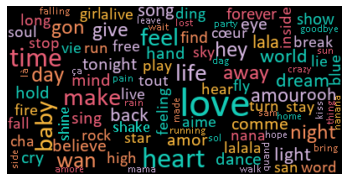

In [133]:
makingclouds(contestants_df[['lyrics']],col='lyrics', maximum=100)

### Piecharts

In [134]:
songs_df.groupby('gender').size().reset_index()

gender    0
0  Female  274
1    Male  244
2     Mix   47

In [135]:
songs_df.columns[0]

'year'

In [148]:
#Count 
counts_df = songs_df.groupby('gender').size().reset_index()
counts_df.columns = [counts_df.columns[0], 'count']
#Calculate porcentages
total_count = counts_df['count'].sum()
counts_df['percentage'] = (counts_df['count'] / total_count) * 100
#Plot
gender_plot = alt.Chart(counts_df).mark_arc().encode(
        theta="count",
        color=alt.Color("gender",scale=alt.Scale(range=eurovision_palette)).title('Gender'),
        tooltip=['gender', 'count', alt.Tooltip('percentage', format='.1f')]
    ).properties(
        title='Main singer(s) gender'
    )
gender_plot.configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24) 

alt.Chart(...)

In [137]:
style_color_map = {
    'Pop': eurovision_palette[0],
    'Dance': eurovision_palette[1],
    'Ballad': eurovision_palette[2],
    'Traditional': eurovision_palette[3],
    'Rock': eurovision_palette[4],
    'Opera': eurovision_palette[5]
}

In [149]:
counts_df = songs_df.groupby('style').size().sort_values().reset_index()
counts_df.columns = [counts_df.columns[0], 'count']
total_count = counts_df['count'].sum()
counts_df['percentage'] = (counts_df['count'] / total_count) * 100
style_plot = alt.Chart(counts_df).mark_arc().encode(
        theta=alt.Theta("count:Q", sort='ascending'),
        color=alt.Color("style:N", scale=alt.Scale(domain=list(style_color_map.keys()),
            range=list(style_color_map.values()))).title('Style'),
        tooltip=['style', 'count', alt.Tooltip('percentage', format='.1f')]
        ).properties(
        title='Music style'
    )
style_plot.configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24) 


alt.Chart(...)

In [139]:
counts_df = songs_df.groupby('backing_dancers').size().sort_values().reset_index()
counts_df.columns = [counts_df.columns[0], 'count']
dancers_plot = alt.Chart(counts_df).mark_arc().encode(
        theta=alt.Theta("count:Q", sort='ascending'),
        color=alt.Color("backing_dancers:Q").scale(range=eurovision_cont_palette, reverse=True).title('Number'),
        tooltip=['backing_dancers', 'count']
        ).properties(
            title='Backing dancers'
        )
dancers_plot

alt.Chart(...)

In [140]:
counts_df = songs_df.groupby('backing_singers').size().sort_values().reset_index()
counts_df.columns = [counts_df.columns[0], 'count']
singers_plot = alt.Chart(counts_df).mark_arc().encode(
        theta=alt.Theta("count:Q", sort='ascending'),
        color=alt.Color("backing_singers:Q").scale(range=eurovision_cont_palette, reverse=True).title('Number'),
        tooltip=['backing_singers', 'count']
        ).properties(
            title='Backing singers'
        )
singers_plot

alt.Chart(...)

In [141]:
counts_df = songs_df.groupby('backing_instruments').size().sort_values().reset_index()
counts_df.columns = [counts_df.columns[0], 'count']
instruments_plot = alt.Chart(counts_df).mark_arc().encode(
        theta=alt.Theta("count:Q", sort='ascending'),
        color=alt.Color("backing_instruments:Q").scale(range=eurovision_cont_palette, reverse=True).title('Number'),
        tooltip=['backing_instruments', 'count']
        ).properties(
            title='Backing instruments'
        )
instruments_plot

alt.Chart(...)

In [143]:
piecharts_cuant = alt.hconcat(singers_plot, dancers_plot, instruments_plot).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24) 
piecharts_cuant

alt.HConcatChart(...)

In [154]:
alt.hconcat(style_plot, gender_plot, singers_plot, dancers_plot, instruments_plot).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24) 


alt.HConcatChart(...)

### 2.4. Voting in Eurovision (2016-2023)

### Suelen acertar las apuestas?

In [158]:
#Get only songs that got into the final
bets_rank_df = bets_df[bets_df['contest_round']=='final'].merge(contestants_df[['year','to_country', 'place_contest', 'points_final']], how='left',
left_on=['year','country_name'], right_on=['year','to_country'])
bets_rank_df = bets_rank_df[bets_rank_df['place_contest'].notnull()]
bets_rank_df['country_group'] = bets_rank_df['country_code'].replace(country_group_mapping)

bets_rank_df.head()

year country_name country_code    song       performer contest_round  \
0  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
1  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
2  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
3  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   
4  2015       Sweden           SE  Heroes  Måns Zelmerlöw         final   

  betting_name  betting_score to_country  place_contest  points_final  \
0       BET365           2.10     Sweden            1.0         365.0   
1       UNIBET           2.00     Sweden            1.0         365.0   
2       YOUWIN           2.38     Sweden            1.0         365.0   
3  BOYLESPORTS           2.25     Sweden            1.0         365.0   
4        CORAL           2.10     Sweden            1.0         365.0   

     country_group  
0  Northern Europe  
1  Northern Europe  
2  Northern Europe  
3  Northern Europe  
4  Northern Europe

In [159]:
bets_rank_df = bets_df[bets_df['contest_round']=='final'].merge(contestants_df[['year','to_country', 'place_contest', 'points_final', 'points_tele_final', 'points_jury_final']], how='left',
left_on=['year','country_name'], right_on=['year','to_country'])
bets_rank_df = bets_rank_df.rename(columns={'points_tele_final':'Televote', 'points_jury_final':'Jury'})
bets_rank_df = bets_rank_df[bets_rank_df['place_contest'].notnull()]
bets_rank_df = bets_rank_df[bets_rank_df['Televote'].notnull()]
bets_rank_df['country_group'] = bets_rank_df['country_code'].replace(country_group_mapping)
bets_points_df = pd.melt(bets_rank_df, id_vars=['country_name','betting_name', 'betting_score', 'year'], value_vars=['Televote', 'Jury'],
    var_name='type', value_name='points')

bets_points_df.head()

country_name  betting_name  betting_score  year      type  points
0       Russia        BET365           1.90  2016  Televote   361.0
1       Russia  BETFAIRSPORT           1.40  2016  Televote   361.0
2       Russia     STANJAMES           1.53  2016  Televote   361.0
3       Russia   BOYLESPORTS           1.40  2016  Televote   361.0
4       Russia   SPORTINGBET           1.30  2016  Televote   361.0

In [160]:
mean_odds_df = bets_points_df.groupby(['year', 'country_name', 'type', 'points']).agg({'betting_score': 'mean'}).reset_index()

# Define the selection
selection = alt.selection_point(fields=['type'], bind='legend')

# Create the scatter plot using Altair
scatter_plot = alt.Chart(mean_odds_df).mark_circle(size=60).encode(
    x=alt.X('betting_score:Q').title('Mean betting score'),
    y=alt.Y('points:Q').title('Points in the final'),
    color=alt.Color('type:N',scale=alt.Scale(range=eurovision_palette)).title('Type of votes'),
    tooltip=['year', 'country_name', 'betting_score']
).properties(
    title='Mean Betting Odds vs Points received (by Country and Year)'
).properties(
    width=600,
    height=400
).add_selection(
    selection
).transform_filter(
    selection
)
# Show the plot
scatter_plot.configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24)  

c:\Users\anaso\anaconda3\lib\site-packages\altair\utils\deprecation.py:65: AltairDeprecationWarning:

'add_selection' is deprecated. Use 'add_params' instead.



alt.Chart(...)

### ¿Suelen coincidir Jurado y Público?

Here we could include a bar filter to select the contest place and another selector for the year 

In [97]:
votes_df = contestants_df[
    contestants_df.year >= 2016][['year', 'to_country', 'points_jury_final', 'points_tele_final', 'place_contest']].dropna()
votes_df.columns = ['year', 'country', 'points_jury_final', 'points_tele_final', 'place_contest']
votes_df['year'] = votes_df['year'].astype('str')

#Scatter plot
scatter = alt.Chart(votes_df).mark_circle(size=60).encode(
    x=alt.X('points_jury_final').title('Points Jury'),
    y=alt.Y('points_tele_final').title('Points Televote'),
    #color='year',
    color = alt.Color('place_contest').scale(range=eurovision_cont_palette, reverse=True).title('Place in final'),
    tooltip=['year', 'country', 'points_jury_final', 'points_tele_final', 'place_contest']
)


scatter.configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24)   

alt.Chart(...)

### ¿Influye si cantas en la primera o última mitad?

In [98]:
#Drops songs that didn't participate in the final
finalists_df = contestants_df[~contestants_df['running_final'].isna()]

#Select data from 2016 to 2023
finalists_df = finalists_df[finalists_df['year'] >= 2016]

#Determine if they performed in the first or second half
finalists_df['final_half'] = pd.cut(finalists_df['running_final'], bins=[0, 14, 27], labels=['1st', '2nd'], right=False)


In [99]:
finalists_df['final_half'].value_counts()

1st    91
2nd    90
Name: final_half, dtype: int64

In [100]:
dist_tele = alt.Chart(finalists_df).transform_density(
        'points_tele_final',
        as_=['points_tele_final', 'density'],
        groupby=['final_half']
    ).mark_area().encode(
        x="points_tele_final:Q",
        y='density:Q',
        color = alt.Color('final_half:N').scale(range=eurovision_palette[:2], reverse=True)
    ).resolve_scale(y='independent')

dist_jury = alt.Chart(finalists_df).transform_density(
        'points_jury_final',
        as_=['points_jury_final', 'density'],
        groupby=['final_half']
    ).mark_area().encode(
        x="points_jury_final:Q",
        y='density:Q',
        color = alt.Color('final_half:N').scale(range=eurovision_palette[:2], reverse=True)
    ).resolve_scale(y='independent')

dist_tele | dist_jury

alt.HConcatChart(...)

In [101]:
points_df = finalists_df[['final_half','points_tele_final', 'points_jury_final']]
points_df.columns = ['final_half', 'Televote', 'Jury']
points_half = pd.melt(points_df, 
            id_vars='final_half', value_vars=['Televote', 'Jury'],
            var_name='voting_type', value_name='points')

boxplot = alt.Chart(points_half).mark_boxplot(ticks={'color':'white'}, size=50, color='white').encode(
        x=alt.X("voting_type:O", title=None, axis=alt.Axis(labels=False, ticks=False), scale=alt.Scale(padding=1)), 
        y=alt.Y("points:Q").title('Points'), 
        color=alt.Color("voting_type:N", scale=alt.Scale(range=eurovision_palette)).title('Voting type'),
        column=alt.Column('final_half:N', header=alt.Header(orient='bottom')).title('Final half')
    ).properties(
        width=200, 
        height=300
    ).configure_facet(
        spacing=0
    ).configure_view(
        stroke=None
    )


boxplot.configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24)   

alt.Chart(...)

In [102]:
from scipy.stats import mannwhitneyu
print(mannwhitneyu(points_df[points_df['final_half']=='1st']['Televote'], 
               points_df[points_df['final_half']=='1st']['Jury']))
print(mannwhitneyu(points_df[points_df['final_half']=='2nd']['Jury'], 
               points_df[points_df['final_half']=='2nd']['Televote']))

MannwhitneyuResult(statistic=3378.5, pvalue=0.03210849233614109)
MannwhitneyuResult(statistic=3954.0, pvalue=0.7846689043262632)


### Most voted countries

In [103]:
votes_df.columns

Index(['year', 'country', 'points_jury_final', 'points_tele_final',
       'place_contest'],
      dtype='object')

In [104]:
total_points_country = votes_df.groupby(['country'], as_index=False)[['points_jury_final', 'points_tele_final']].sum()
# create a bar chart with a ranking
ranking_jury = (
    alt.Chart(total_points_country).mark_bar(color = eurovision_palette[0]).encode(
        x=alt.X("points_jury_final").title('Points'),
        y=alt.Y("country").title('Country').sort("-x"),
    ).transform_window(
    rank='rank(points_jury_final)',
    sort=[alt.SortField('points_jury_final', order='descending')]
).transform_filter(
    alt.datum.rank <= 10).properties(
        width=300,
        height=250,
        title="Most voted by Jury"
    )
)

ranking_tele = (
    alt.Chart(total_points_country).mark_bar(color = eurovision_palette[1]).encode(
        x=alt.X("points_tele_final").title('Points'),
        y=alt.Y("country").title('Country').sort("-x"),
    ).transform_window(
    rank='rank(points_tele_final)',
    sort=[alt.SortField('points_tele_final', order='descending')]
).transform_filter(
    alt.datum.rank <= 10).properties(
        width=300,
        height=250,
        title="Most voted by Televote"
    )
)

alt.hconcat(ranking_jury,ranking_tele).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
titleFontSize=15,
labelFontSize=15
).configure_title(fontSize=24)   

alt.HConcatChart(...)